<a href="https://colab.research.google.com/github/sarathsreedharan/CSU_CS_445/blob/main/Spring25/Notebooks/module07-1-others.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Non-Neural Methods: KNN, SVMs, and Decision Trees

*Adapted from https://www.kaggle.com/code/jchen2186/machine-learning-with-iris-dataset/data, https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47, https://medium.com/analytics-vidhya/iris-data-prediction-using-decision-tree-algorithm-7948fb68201b*

Neural networks are not the only game in town!  Here are some other, non-neural machine learning methods you should have in your arsenal.

**K-Nearest Neighbors Classifier**, **Support Vector Machine**, and **Decision Tree**

Advantages:
* Fast to train
* Need less data
* Explainable

Disadvantages:
* Require manual feature selection
* Not easy to generalize

In [6]:
#!pip install seaborn
#!pip install sklearn
#!pip install graphviz

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

data = pd.read_csv('Iris.csv')

## Meet the Iris Dataset

Fisher's Iris data set is a multivariate data set introduced by the British statistician and biologist Ronald Fisher in his 1936 paper *The use of multiple measurements in taxonomic problems as an example of linear discriminant analysis*.

<img src="https://upload.wikimedia.org/wikipedia/commons/5/56/Kosaciec_szczecinkowaty_Iris_setosa.jpg" width=200>
$$Iris\text{ }setosa$$

<img src="https://upload.wikimedia.org/wikipedia/commons/4/41/Iris_versicolor_3.jpg" width=200>
$$Iris\text{ }versicolor$$

<img src="https://upload.wikimedia.org/wikipedia/commons/9/9f/Iris_virginica.jpg" width=200>
$$Iris\text{ }virginica$$

What we want to do is classify the species of iris given some measurements about the blossom.

# Preview of Data
- There are 150 observations with 4 features each (sepal length, sepal width, petal length, petal width).
- There are no null values, so we don't have to worry about that.
- There are 50 observations of each species (setosa, versicolor, virginica).

In [8]:
data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


In [10]:
data.describe()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,75.500000,5.843333,3.054000,3.758667,1.198667
std,43.445368,0.828066,0.433594,1.764420,0.763161
min,1.000000,4.300000,2.000000,1.000000,0.100000
25%,38.250000,5.100000,2.800000,1.600000,0.300000
50%,75.500000,5.800000,3.000000,4.350000,1.300000
75%,112.750000,6.400000,3.300000,5.100000,1.800000
max,150.000000,7.900000,4.400000,6.900000,2.500000


In [11]:
data['Species'].value_counts()

,count
Species,
Iris-setosa,50
Iris-versicolor,50
Iris-virginica,50


# Data Visualization
- After graphing the features in a pair plot, it is clear that the relationship between pairs of features of a iris-setosa (in pink) is distinctly different from those of the other two species.
- There is some overlap in the pairwise relationships of the other two species, iris-versicolor (brown) and iris-virginica (green).


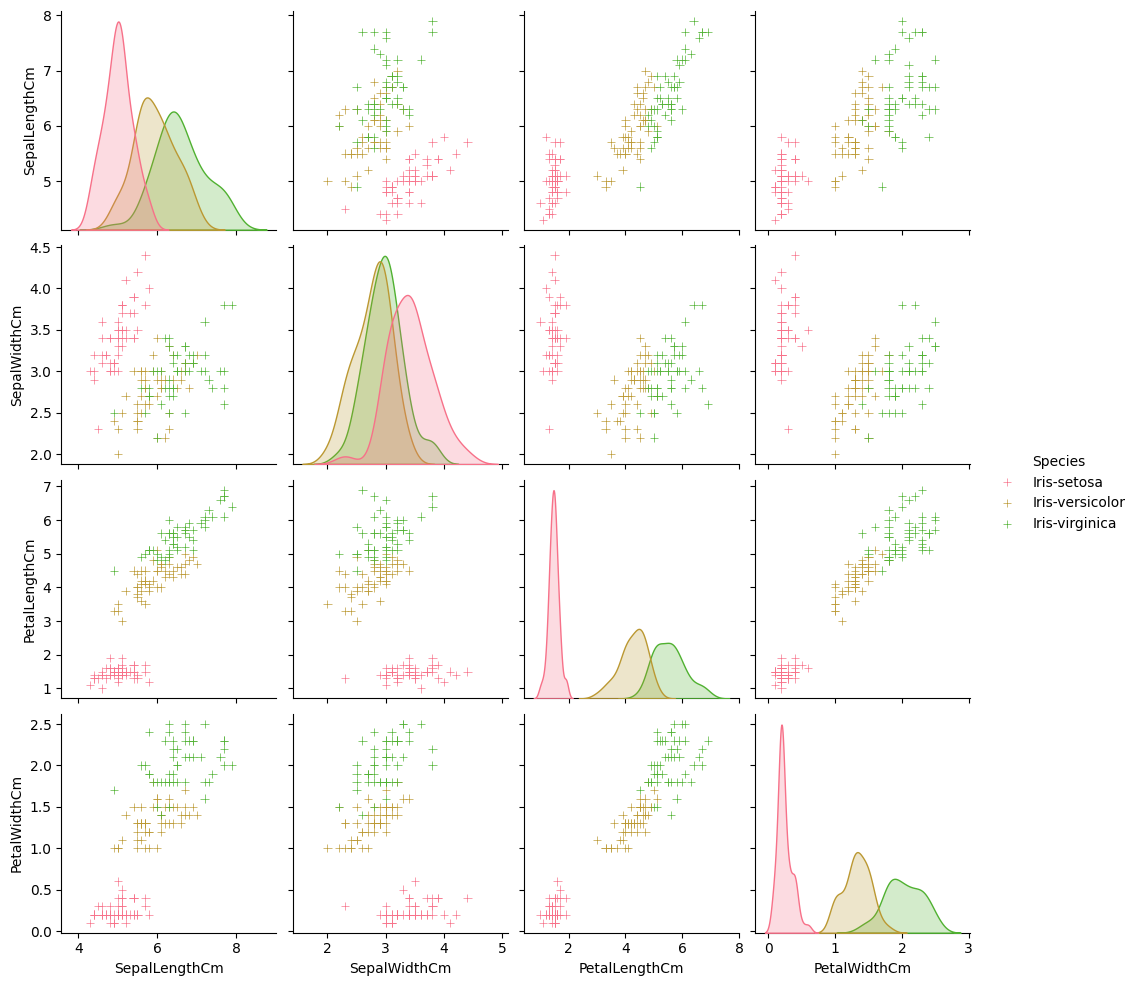

In [12]:
tmp = data.drop('Id', axis=1)
g = sns.pairplot(tmp, hue='Species', markers='+')
plt.show()

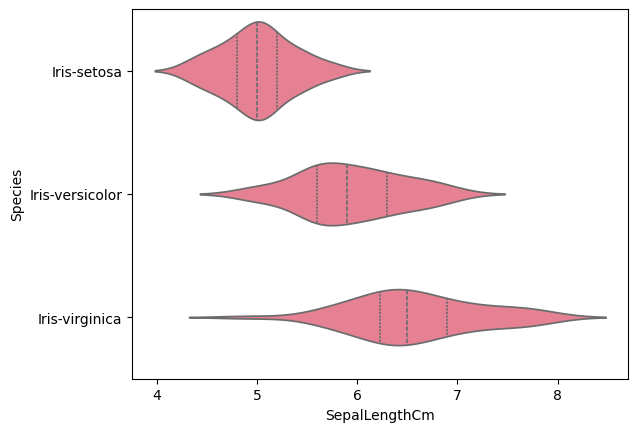

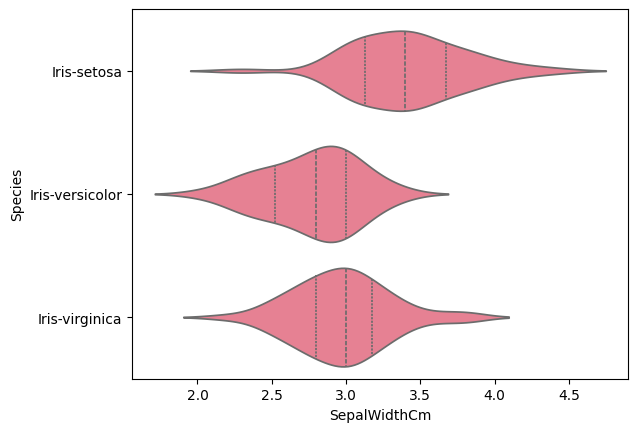

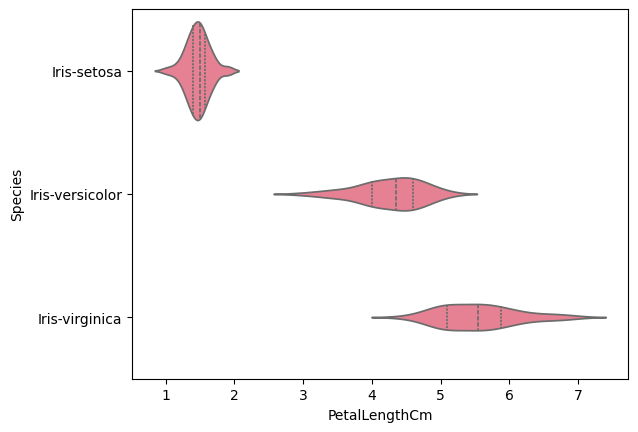

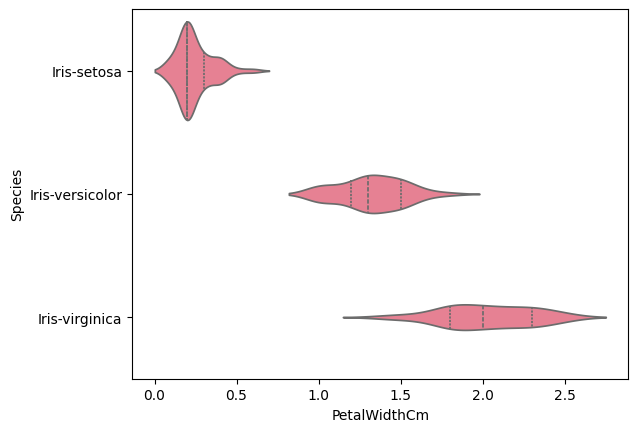

In [13]:
g = sns.violinplot(y='Species', x='SepalLengthCm', data=data, inner='quartile')
plt.show()
g = sns.violinplot(y='Species', x='SepalWidthCm', data=data, inner='quartile')
plt.show()
g = sns.violinplot(y='Species', x='PetalLengthCm', data=data, inner='quartile')
plt.show()
g = sns.violinplot(y='Species', x='PetalWidthCm', data=data, inner='quartile')
plt.show()

We will evaluate the KNN, SVM, and Decision Tree algorithms on this dataset.  In each case, first we'll do it using the version from scikit-learn, and then we'll build our own.  We'll also compare with logistic regression, which we already have done, as a baseline.

## K-Nearest Neighbors Classifier

K-nearest neighbors algorithm can be used for both classification and regression.  In both cases, the input consists of the $k$ closest training examples in a data set.  The output is a class membership. An object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its $k$ nearest neighbors ($k$ is a positive integer, typically small).

<img src="https://upload.wikimedia.org/wikipedia/commons/e/e7/KnnClassification.svg" width=200>
$$\text{What class does the green circle belong to?}$$

## Modeling with scikit-learn

In [14]:
# Load iris data and store in dataframe

from sklearn import datasets

iris = datasets.load_iris()

df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [15]:
# Separate X and y data

X = df.drop('target', axis=1)
y = df.target

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data - 75% train, 25% test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                   random_state=1)

# Scale the X data

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

clf = KNeighborsClassifier(n_neighbors=5, p=1)
clf.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)

print(f"Sklearn KNN Accuracy: {accuracy_score(y_test, y_pred_test)}")

Sklearn KNN Accuracy: 0.9736842105263158


## KNN from scratch

In [18]:
# Load data

iris = datasets.load_iris()

df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target

# Separate X and y data

X = df.drop('target', axis=1)
y = df.target

1. Define a function to calculate the distance between two points
2. Use the distance function to get the distance between a test point and all known data points
3. Sort distance measurements to find the points closest to the test point (i.e., find the nearest neighbors)
4. Use majority class labels of those closest points to predict the label of the test point
5. Repeat steps 1 through 4 until all test data points are classified

### 1. Define a function to calculate the distance between two points

In [19]:
# Calculate distance between two points

def minkowski_distance(a, b, p=1):

    # Store the number of dimensions
    dim = len(a)

    # Set initial distance to 0
    distance = 0

    # Calculate minkowski distance using parameter p
    for d in range(dim):
        distance += abs(a[d] - b[d])**p

    distance = distance**(1/p)

    return distance


# Test the function

minkowski_distance(a=X.iloc[0], b=X.iloc[1], p=1)

<ipython-input-19-b43fb3df34e5>:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  distance += abs(a[d] - b[d])**p


np.float64(0.6999999999999993)

### 2. Use the distance function to get the distance between a test point and all known data points

In [20]:
# Define an arbitrary test point

test_pt = [4.8, 2.7, 2.5, 0.7]

# Calculate distance between test_pt and all points in X

distances = []

for i in X.index:

    distances.append(minkowski_distance(test_pt, X.iloc[i]))

df_dists = pd.DataFrame(data=distances, index=X.index, columns=['dist'])
df_dists.head()

<ipython-input-19-b43fb3df34e5>:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  distance += abs(a[d] - b[d])**p


,dist
0,2.7
1,2.0
2,2.3
3,2.1
4,2.7


### 3. Sort distance measurements to find the points closest to the test point

In [21]:
# Find the 5 nearest neighbors

df_nn = df_dists.sort_values(by=['dist'], axis=0)[:5]
df_nn

,dist
98,1.4
57,1.5
93,1.7
24,1.8
45,1.8


### 4. Use majority class labels of those closest points to predict the label of the test point

In [22]:
from collections import Counter

# Create counter object to track the labels

counter = Counter(y[df_nn.index])

# Get most common label of all the nearest neighbors

counter.most_common()[0][0]

1

### 5. Repeat steps 1 through 4 until all test data points are classified

In [23]:
# Split the data - 75% train, 25% test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                   random_state=1)

# Scale the X data

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
def knn_predict(X_train, X_test, y_train, y_test, k, p):

    # Counter to help with label voting
    from collections import Counter

    # Make predictions on the test data
    # Need output of 1 prediction per test data point
    y_hat_test = []

    for test_point in X_test:
        distances = []

        for train_point in X_train:
            distance = minkowski_distance(test_point, train_point, p=p)
            distances.append(distance)

        # Store distances in a dataframe
        df_dists = pd.DataFrame(data=distances, columns=['dist'],
                                index=y_train.index)

        # Sort distances, and only consider the k closest points
        df_nn = df_dists.sort_values(by=['dist'], axis=0)[:k]

        # Create counter object to track the labels of k closest neighbors
        counter = Counter(y_train[df_nn.index])

        # Get most common label of all the nearest neighbors
        prediction = counter.most_common()[0][0]

        # Append prediction to output list
        y_hat_test.append(prediction)

    return y_hat_test

In [25]:
# Make predictions on test dataset
y_hat_test = knn_predict(X_train, X_test, y_train, y_test, k=5, p=1)

print(y_hat_test)
print(f"My KNN Accuracy: {accuracy_score(y_test, y_pred_test)}")

[0, 1, 1, 0, 2, 1, 2, 0, 0, 2, 1, 0, 2, 1, 1, 0, 1, 1, 0, 0, 1, 1, 2, 0, 2, 1, 0, 0, 1, 2, 1, 2, 1, 2, 2, 0, 1, 0]
My KNN Accuracy: 0.9736842105263158


In [26]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_hat_test)

array([[13,  0,  0],
       [ 0, 15,  1],
       [ 0,  0,  9]])

## Support Vector Machine Classifier

A support-vector machine constructs a hyperplane or set of hyperplanes in a high- or infinite-dimensional space that separates regions in the data by the maximum amount possible.  Intuitively, a good separation is achieved by the hyperplane that has the largest distance to the nearest training-data point of any class. In general the larger the margin, the lower the generalization error of the classifier.

<img src="https://upload.wikimedia.org/wikipedia/commons/7/72/SVM_margin.png" width=200>
$$\text{Samples on the margins are called the "support vectors"}$$

## Modeling with scikit-learn

In [27]:
from sklearn import svm

iris = datasets.load_iris()

df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target

X = df.drop('target', axis=1)[:100]
y = df.target[:100]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                   random_state=1)

clf = svm.LinearSVC(C=1.0, max_iter=10000)

clf.fit(X, y)

y_pred_test = clf.predict(X_test)

print(y_pred_test)
print(f"Sklearn Multinomial SVM Accuracy: {accuracy_score(y_test, y_pred_test)}")

[1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 0 0 1 1 1 0]
Sklearn Multinomial SVM Accuracy: 1.0


## SVM from scratch

In [28]:
iris = datasets.load_iris()

df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target
df = df.drop(df.index[range(100,150)])

X = df.drop('target', axis=1)
y = df.target
y[y == 0] = -1

<ipython-input-28-ff11d5e16412>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y == 0] = -1


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                   random_state=1)
y_train = np.array(y_train)

In [43]:
train_f1 = np.array(X_train.iloc[:,0])
train_f2 = np.array(X_train.iloc[:,1])
train_f3 = np.array(X_train.iloc[:,2])
train_f4 = np.array(X_train.iloc[:,3])

train_f1 = train_f1.reshape(75,1)
train_f2 = train_f2.reshape(75,1)
train_f3 = train_f3.reshape(75,1)
train_f4 = train_f4.reshape(75,1)

w1 = 0 #np.zeros((75,1))
w2 = 0 #np.zeros((75,1))
w3 = 0 #np.zeros((75,1))
w4 = 0 #np.zeros((75,1))

epochs = 1
alpha = 0.0001

while(epochs < 10000):
    y = w1 * train_f1 + w2 * train_f2 + w3 * train_f3 + w4 * train_f4
    prod = y.reshape(-1,) * y_train
    count = 0
    for val in prod:
        if (val >= 1):
            #cost = 0
            w1 = w1 - alpha * (2 * 1/epochs * w1)
            w2 = w2 - alpha * (2 * 1/epochs * w2)
            w3 = w3 - alpha * (2 * 1/epochs * w3)
            w4 = w4 - alpha * (2 * 1/epochs * w4)
        else:
            #cost = 1 - val
            w1 = w1 + alpha * (train_f1[count] * y_train[count] - 2 * 1/epochs * w1)
            w2 = w2 + alpha * (train_f2[count] * y_train[count] - 2 * 1/epochs * w2)
            w3 = w3 + alpha * (train_f3[count] * y_train[count] - 2 * 1/epochs * w3)
            w4 = w4 + alpha * (train_f4[count] * y_train[count] - 2 * 1/epochs * w4)
        count += 1
    epochs += 1

In [45]:
## Extract the test data features
test_f1 = np.array(X_test.iloc[:,0])
test_f2 = np.array(X_test.iloc[:,1])
test_f3 = np.array(X_test.iloc[:,2])
test_f4 = np.array(X_test.iloc[:,3])

## Predict
y_pred = w1 * test_f1 + w2 * test_f2 + w3 * test_f3 + w4 * test_f4
predictions = []
for val in y_pred:
    if(val > 1):
        predictions.append(1)
    else:
        predictions.append(-1)

print(predictions)
print(f"My SVM Accuracy: {accuracy_score(y_test, predictions)}")

[1, 1, -1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, 1, 1, 1, -1]
My SVM Accuracy: 1.0


In [46]:
confusion_matrix(np.array(y_test), predictions)

array([[10,  0],
       [ 0, 15]])

### Multinomial SVM with sklearn

Add back in all classes

In [47]:
from sklearn import svm

iris = datasets.load_iris()

df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target

X = df.drop('target', axis=1)
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                   random_state=1)

clf = svm.LinearSVC(C=1.0, max_iter=10000)

clf.fit(X, y)

y_pred_test = clf.predict(X_test)

print(y_pred_test)
print(f"Sklearn Multinomial SVM Accuracy: {accuracy_score(y_test, y_pred_test)}")

[0 1 1 0 2 1 2 0 0 2 1 0 2 1 1 0 1 1 0 0 1 2 1 0 2 1 0 0 1 2 1 2 1 2 2 0 1
 0]
Sklearn Multinomial SVM Accuracy: 0.9736842105263158


In [ ]:
# Different SVM types

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = (
    svm.SVC(kernel="linear", C=C),
    svm.LinearSVC(C=C, max_iter=10000),
    svm.SVC(kernel="rbf", gamma=0.7, C=C), # radial basis function kernel
    svm.SVC(kernel="poly", degree=3, gamma="auto", C=C), # polynomial kernel
)
models = (clf.fit(X, y) for clf in models)

In [ ]:
y_pred_test = [clf.predict(X_test) for clf in models]

In [ ]:
for pred in y_pred_test:
    print(f"Sklearn SVM Accuracy: {accuracy_score(y_test, pred)}")

Sklearn SVM Accuracy: 1.0
Sklearn SVM Accuracy: 0.9736842105263158
Sklearn SVM Accuracy: 0.9736842105263158
Sklearn SVM Accuracy: 1.0


In [ ]:
[confusion_matrix(y_test, y_hat_test) for y_hat_test in y_pred_test[1:3]]

[array([[13,  0,  0],
        [ 0, 15,  1],
        [ 0,  0,  9]]),
 array([[13,  0,  0],
        [ 0, 15,  1],
        [ 0,  0,  9]])]

### Kernel in SVM?

What's the kernel in an SVM?

For many algorithms, raw data must be transformed into a *feature vector*.  This can be done through an explicitly-defined mapping function, or can be transformed into a feature map a la a CNN through mutiplication by a matrix.  This matrix multiplication is just a function $f$ parameterized by weights $W$: $f(X;W) \rightarrow U$.

That matrix is a convolutional filter a.k.a. a *kernel*.

The *other* kind of kernel is a user-specified similarity function over pairs of data points in raw representation.  This is the kernel at work in an SVM.

For instance, the radial basis function (RBF) kernel:
$$K(x,x') = \text{exp}\Big(\frac{\Vert x-x'\Vert^2}{2\sigma^2}\Big)$$

$\Vert x-x'\Vert^2$ is the squared Euclidean distance between two samples, and $\sigma$ is a free tunable parameter.

# Decision Tree

A decisions tree is built on a source set.  The entire set is considered the root of the tree and every sample in the set has a target value (class, in the case of classification).  At each step, we split into subsets, which each constitute children.

The splitting is based on a set of splitting rules based on classification features.

This process is repeated recursively on each derived subset. The recursion is complete when the subset at a node has all the same values of the target variable, or when splitting no longer adds value to the predictions.

<img src="https://upload.wikimedia.org/wikipedia/commons/e/eb/Decision_Tree.jpg" width=400>
$$\text{Your chances of survival were good if you were (i) a female or (ii) a male younger than 9.5 years with strictly less than 3 siblings.}$$

## Modeling with sklearn

In [48]:
from sklearn import tree
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score

In [49]:
iris = datasets.load_iris()

df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target

df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [50]:
X = np.array(df[['sepal length (cm)',\
       'sepal width (cm)',\
       'petal length (cm)',\
       'petal width (cm)']])
y = np.array(df['target'])

[Text(0.4, 0.9166666666666666, 'x[3] <= 0.8\ngini = 0.665\nsamples = 112\nvalue = [37, 34, 41]'),
 Text(0.3, 0.75, 'gini = 0.0\nsamples = 37\nvalue = [37, 0, 0]'),
 Text(0.35, 0.8333333333333333, 'True  '),
 Text(0.5, 0.75, 'x[3] <= 1.65\ngini = 0.496\nsamples = 75\nvalue = [0, 34, 41]'),
 Text(0.45, 0.8333333333333333, '  False'),
 Text(0.2, 0.5833333333333334, 'x[2] <= 4.95\ngini = 0.193\nsamples = 37\nvalue = [0, 33, 4]'),
 Text(0.1, 0.4166666666666667, 'gini = 0.0\nsamples = 32\nvalue = [0, 32, 0]'),
 Text(0.3, 0.4166666666666667, 'x[0] <= 6.05\ngini = 0.32\nsamples = 5\nvalue = [0, 1, 4]'),
 Text(0.2, 0.25, 'x[2] <= 5.05\ngini = 0.5\nsamples = 2\nvalue = [0, 1, 1]'),
 Text(0.1, 0.08333333333333333, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.3, 0.08333333333333333, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0]'),
 Text(0.4, 0.25, 'gini = 0.0\nsamples = 3\nvalue = [0, 0, 3]'),
 Text(0.8, 0.5833333333333334, 'x[2] <= 4.85\ngini = 0.051\nsamples = 38\nvalue = [0, 1, 37]'),
 

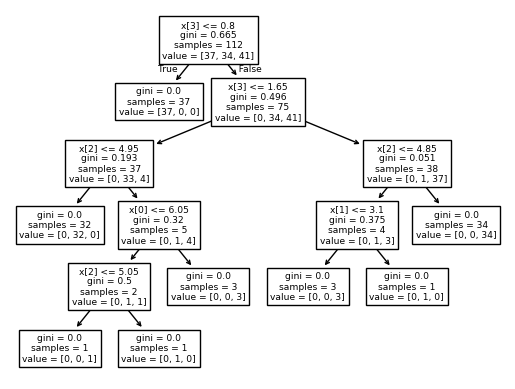

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

clf = DecisionTreeClassifier(criterion='gini',min_samples_split=2)
clf.fit(X_train, y_train)

tree.plot_tree(clf)

That's to small to see to let's use the `graphviz` library to get a better look.

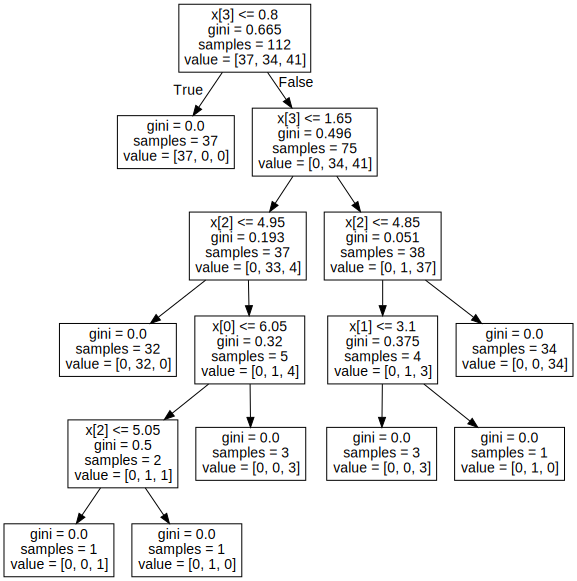

In [52]:
#Visualizing Decision Tree using graphviz library

dot_data = tree.export_graphviz(clf, out_file=None)

graph = graphviz.Source(dot_data)
graph

In [53]:
y_pred_test = clf.predict(X_test)

print(f"Sklearn Decision Tree Accuracy: {accuracy_score(y_test, y_pred_test)}")

Sklearn Decision Tree Accuracy: 0.9736842105263158


In [54]:
confusion_matrix(y_test, y_pred_test)

array([[13,  0,  0],
       [ 0, 15,  1],
       [ 0,  0,  9]])

Same as the others!

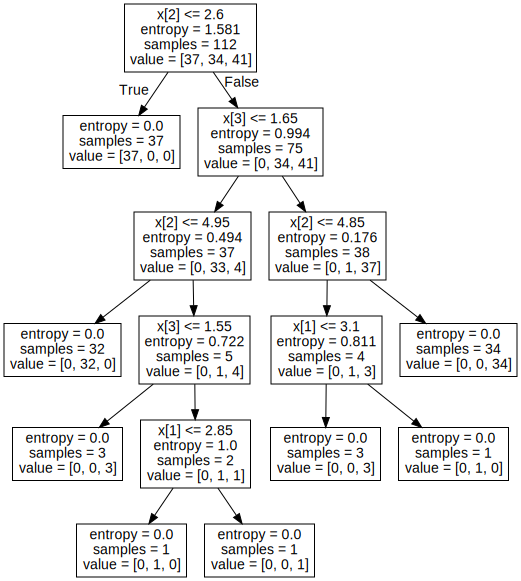

In [55]:
# entropy criterion
clf = DecisionTreeClassifier(criterion='entropy',min_samples_split=2)
clf.fit(X_train, y_train)

dot_data = tree.export_graphviz(clf, out_file=None)

graph = graphviz.Source(dot_data)
graph

In [56]:
y_pred_test = clf.predict(X_test)

print(f"Sklearn Decision Tree Accuracy: {accuracy_score(y_test, y_pred_test)}")
confusion_matrix(y_test, y_pred_test)

Sklearn Decision Tree Accuracy: 0.9736842105263158


array([[13,  0,  0],
       [ 0, 15,  1],
       [ 0,  0,  9]])

### Criteria: Gini Impurity vs. Entropy

Gini impurity:

$$1-\sum_j p_j^2$$

Entropy:

$$-\sum_j p_j \text{log}_2(p_j)$$

The **Gini impurity** measures the frequency at which any element of the dataset will be mislabelled when it is randomly labeled.

**Entropy** is a measure of information that indicates the disorder of the features with the target.

In both cases, the optimum split is the feature with the lowest criterion value.